## Datalake et sources de données

D'une façon générale, il est important d'avoir une bonne compréhension sur les entrées et sorties d'un processus. C'est primordial lorsque l'on souhaite distribuer la réalisation d'un processus.

Dans une phase de création, le datascientist va généralement s'appuyer sur un datalake : des données relativement brutes qu'il va chercher à exploiter. Ce datalake prend généralement la forme d'un système de fichier distribué. 

Spark s'appuie sur les librairies hadoop pour récupérer en mémoire les données qui se trouvent dans le datalake. La majorité des datalakes utilisent la technologie HDFS (Hadoop Distributed File System). Néanmoins ce n'est pas le choix que nous avons fait sur le datalab. 

#### Le choix d'un datalake basé sur S3

Ce tutorial se concentre sur la connexion de spark à une source de donnée fichier au sens large. D'autres sources sont possibles (SGBD, base no sql). En particulier nous nous concentrons sur le stockage orienté objet avec l'API S3. Pourquoi un stockage S3 plutôt que HDFS, le système de stockage distribué d'Hadoop ? HDFS est apparu avec la nécessité de **colocaliser les traitements et les données** dans le monde du BigData. C'était un concept fort poussé par Map&Reduce suite aux travaux de google en 2004.
Pour faire court ce modèle décline, c'est trop cher à maintenir et ca correspond de moins en moins à nos processus de traitement de données. En effet, aujourd'hui beaucoup de projets font intervenir des méthodes de machine learning, donc des modèles couteux à entrainer en CPU/GPU (voire TPU), mais sur des jeux de données généralement de taille limitée. La nouvelle tendance sera donc sans doute de découpler la croissance de la capacité de stockage et celle de traitement. Et si cette tendance se confirme alors le stockage S3 qui est une API de distribution d'objet (fichier + metadonnées associées) se développera fortement, profitant de l'appui des offreurs de cloud public et de ses qualités intrinsèques :
* une API http donc facilement accessible
* compatible avec Hadoop pour en être une source de donnée
* des fonctions de chiffrement et d'authentification à la demande

Bref c'est ce modèle qu'on met en avant dans le datalab pour sa facilité d'implémentation, sa facilité de sécurisation et d'audit, son cout plus faible, au risque de perdre un peu en vitesse avec la non colocalisation des traitements et des données.


### Let's go

Pas de changement, on lance notre contexte spark local.. un autre jour pour passer la distribution des calculs dans un cluster.

In [1]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .appName("Datalake TP")
         .master("local[5]")
         .getOrCreate()
        )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2021-10-29 13:01:03,894 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Les données : sirene opendata

J'ai mis dans un bucket de projet (projet-spark-lab) des données open data de la base sirene, dans le **dossier diffusion qui est accessible en consultation à chaque personne ayant un compte dans le datalab.. Ceci est vrai pour tous les buckets, y compris tous les votres.**

Il est important de noter que notre Datalake a tout d'un DataSwamp : sans gouvernance, sans moteur de recherche c'est un vrai marécage de données où les duplications de données seront légions.

Le code-ci dessous vous montre le fichier en question dans cet espace de stockage de projet avec la librairie python s3fs (pas de spark ici)

In [2]:
import s3fs
endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
fs.info('s3://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv')

{'ETag': '"f2954aae6c983505882aa894fb0faa91-419"',
 'Key': 'projet-spark-lab/diffusion/formation/data/sirene/sirene.csv',
 'LastModified': datetime.datetime(2021, 9, 8, 16, 14, 17, 574000, tzinfo=tzlocal()),
 'Size': 7019714602,
 'size': 7019714602,
 'name': 'projet-spark-lab/diffusion/formation/data/sirene/sirene.csv',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None}

### Chargement des données et SparkSQL

Dans l'introduction, nous avions utlisé uniquement des RDD. https://spark.apache.org/docs/latest/rdd-programming-guide.html
C'est une interface de programmation de bas niveau qui donne une grande liberté de développement sur des fichiers non structurés mais en pratique on a le plus souvent des données structurées, notamment sous forme de table. Dès lors, le modèle des Spark DataFrames et l'interface de programmation SparkSQL permettent une manipulation plus simple, avec des optimisations issues des théories de l'algébre relationnelle.


Nous allons charger le fichier csv avec la méthode suivante en inférant le schéma.

**Spark va alors devoir lire une seconde fois l'ensemble du fichier pour déduire le type de chaque colonne du fichier**

In [4]:
df = (spark
      .read.format("csv")
      .options(header='true', inferschema='true', delimiter=',')
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )

In [5]:
df.printSchema()

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

In [6]:
df

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

Une fois le schéma inféré ou imposé, on peut directement faire des opérations sur les données.

In [8]:
# Via les opérations sur les DataFrames

df.select("siren", "siret").show(5)

+------+-----------+
| siren|      siret|
+------+-----------+
|325175|32517500016|
|325175|32517500016|
|325175|32517500016|
|325175|32517500024|
|325175|32517500024|
+------+-----------+
only showing top 5 rows



In [13]:
# Via des reqûetes SQL, en créant une vue de la table
df.createOrReplaceTempView("sirene")

sqlDF = spark.sql("SELECT siren, siret FROM sirene LIMIT 10")
sqlDF.show()

print(sqlDF.count())

+------+-----------+
| siren|      siret|
+------+-----------+
|325175|32517500016|
|325175|32517500016|
|325175|32517500016|
|325175|32517500024|
|325175|32517500024|
|325175|32517500032|
|325175|32517500032|
|325175|32517500040|
|325175|32517500040|
|325175|32517500057|
+------+-----------+



10


#### Schéma pour la consultation des données sur S3 

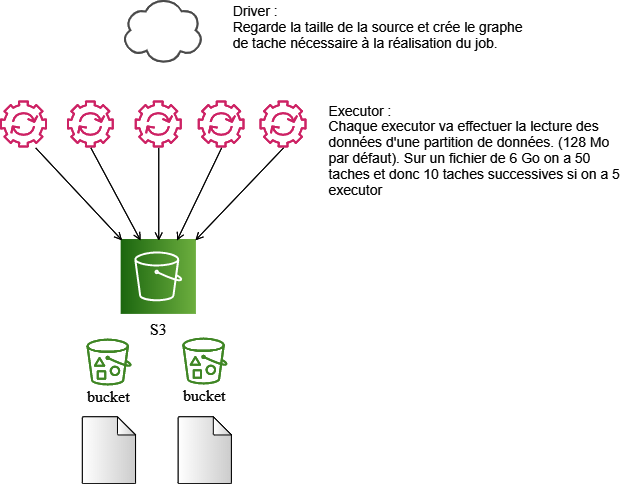

### Conclusion

Au sein du datalab, l'accès à votre espace personnel de données depuis spark est pris en charge directement par l'infrastructure. 
L'effort est minimal puisqu'il vous suffit d'indiquer l'url du fichier précéder du procotole s3a. **s3a://bucket/path/du/fichier**

Avoir un système de fichier distribué est le prérequis pour commencer à distribuer son calcul sur un **cluster de machine**.

In [14]:
spark.stop()